# Load libraries and data

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(dada2) ; packageVersion("dada2")
library(decontam) ; packageVersion("decontam")
library(ggplot2); packageVersion("ggplot2")
library(vegan); packageVersion("vegan")
library(DESeq2); packageVersion("DESeq2")
library(Biostrings); packageVersion("Biostrings")
library(tidyr)
library(dplyr)
library(scales)
library(repr)
library(reshape2)
library(genefilter)
#library(VennDiagram)
#library(svglite)
#library(gridExtra)

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.28.0’

Loading required package: Rcpp


[1] ‘1.12.1’

[1] ‘1.4.0’

[1] ‘3.2.1’

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


[1] ‘2.5.6’

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

[1] ‘1.24.0’

Loading required package: XVector

Attaching package: ‘Biostrings’

The following object is masked from ‘package:DelayedArray’:

    type

The following object is masked from ‘package:base’:

    strsplit



[1] ‘2.52.0’


Attaching package: ‘tidyr’

The following object is masked from ‘package:S4Vectors’:

    expand


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union

The following object is masked from ‘package:XVector’:

    slice

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stat

In [2]:
#save in case needed:
location_levels = c(
    'field_blank',
    'RO_BF_control',
    'negative_control',
    'WW_3ary',
    'BAC',
    'MF_combined',
    'MF_tank',
    'RO_BF_retentate_scrapings',
    'RO_BF_separator',
    'RO_combined',
    'RO_3stage', 'RO_2stage', 'RO',
    'Loop_DPWF_inf', 'Loop_MWTP_inf', 'Loop_1', 'Loop_2', 'Loop_3', 'Loop_4', 'Loop_5',
    'DWDS_328', 'DWDS_286', 'DWDS_282B')
#sample_data(ps_samp_blank)$location_code <- factor(sample_data(ps_samp_blank)$location_code, 
#                            levels=location_levels)


In [3]:
ps_raw <- readRDS("~/data/awtp2_16S/ps_raw_from_dada2.rds")
ps_raw

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 186 samples ]
sample_data() Sample Data:       [ 186 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 6 taxonomic ranks ]

In [4]:
#rename ASVs with short names, save DNA seq in ps
#dna <- Biostrings::DNAStringSet(taxa_names(ps_raw))
#names(dna) <- taxa_names(ps_raw)
#ps_raw <- merge_phyloseq(ps_raw, dna)
#taxa_names(ps_raw) <- paste0("ASV", seq(ntaxa(ps_raw)))

In [5]:
#EXAMPLE: extracting a single sequence from the DNAStringSet object
#as.character(refseq(ps_raw)['ASV1'])

In [6]:
#make "combined" column in tax table
ranks <- c("Phylum", "Family", "Genus")
combined_labels <- apply(tax_table(ps_raw)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
tax_table(ps_raw) <- cbind(tax_table(ps_raw), combined=combined_labels)


In [7]:
sample_data(ps_raw)[sample_data(ps_raw)=="Low"] <- NA #sub NA for Low values
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[sample_data(ps_raw)$DNA_Ext_conc_ngperuL=="Low"] <- NA
sample_data(ps_raw)$DNA_Ext_conc_ngperuL <- as.numeric(as.character(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)) #convert from factor to decimal
sample_data(ps_raw)$DNA_Ext_conc_ngperuL[is.na(sample_data(ps_raw)$DNA_Ext_conc_ngperuL)] <- 0.0002

In [8]:
#remove samples with too few reads
min_reads <- 7500
ps <- prune_samples(sample_sums(ps_raw)>=min_reads, ps_raw) #remove failed samples
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7271 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7271 taxa by 7 taxonomic ranks ]

In [9]:
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))


# Number of reads per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


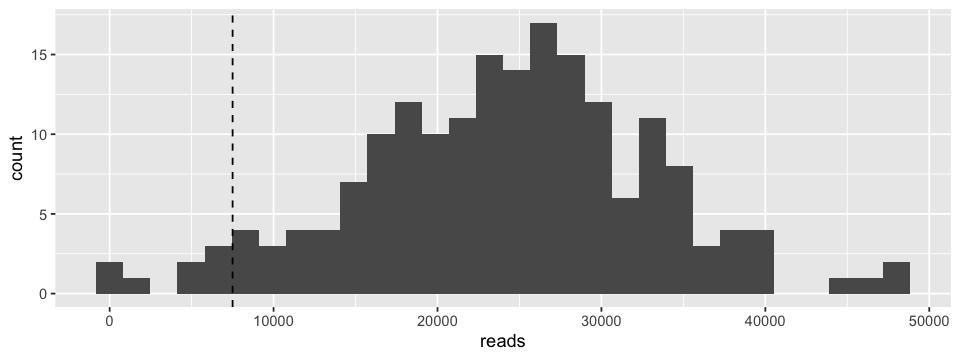

In [10]:
read_counts <- as.data.frame(rowSums(otu_table(ps_raw)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram()+
    geom_vline(xintercept=min_reads, linetype='dashed')

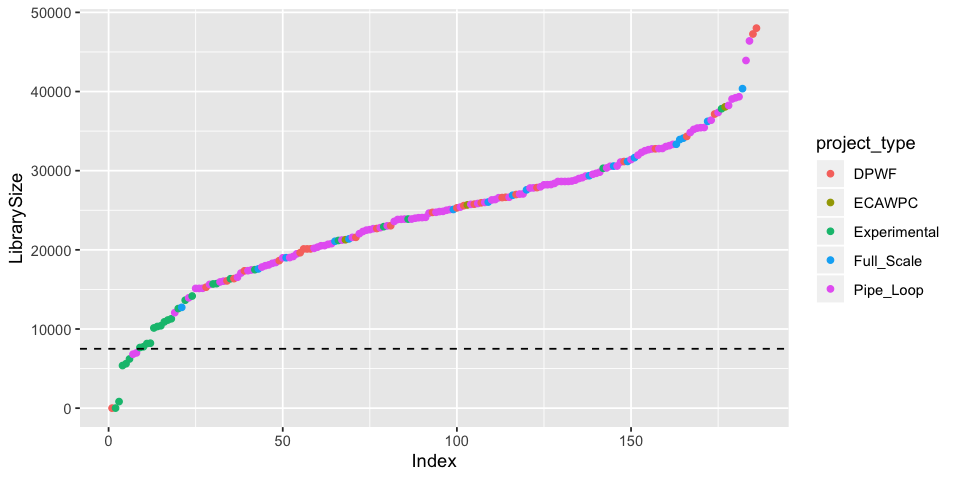

In [11]:
df <- as.data.frame(sample_data(ps_raw)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_raw)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=project_type))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')


# Number of ASVs per sample, including controls

In [12]:
sample_data(ps)$project_type <- factor(sample_data(ps)$project_type,
                                       levels=c('Experimental', 'ECAWPC', 'DPWF', 'Pipe_Loop', 'Full_Scale'))

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

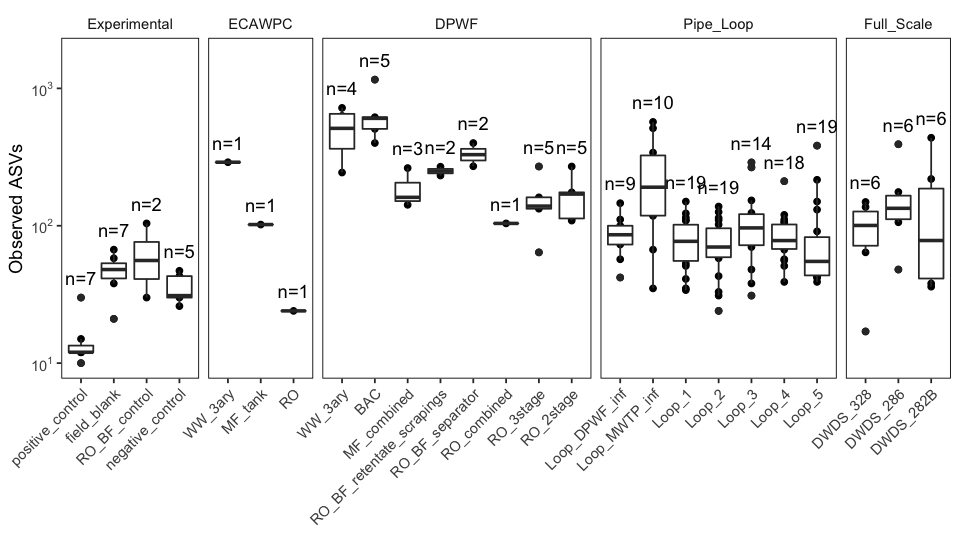

In [13]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 8, repr.plot.height = 4.5)
plot_richness(ps, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    facet_grid(.~project_type, scale="free_x", space="free_x")

# Examine positive controls

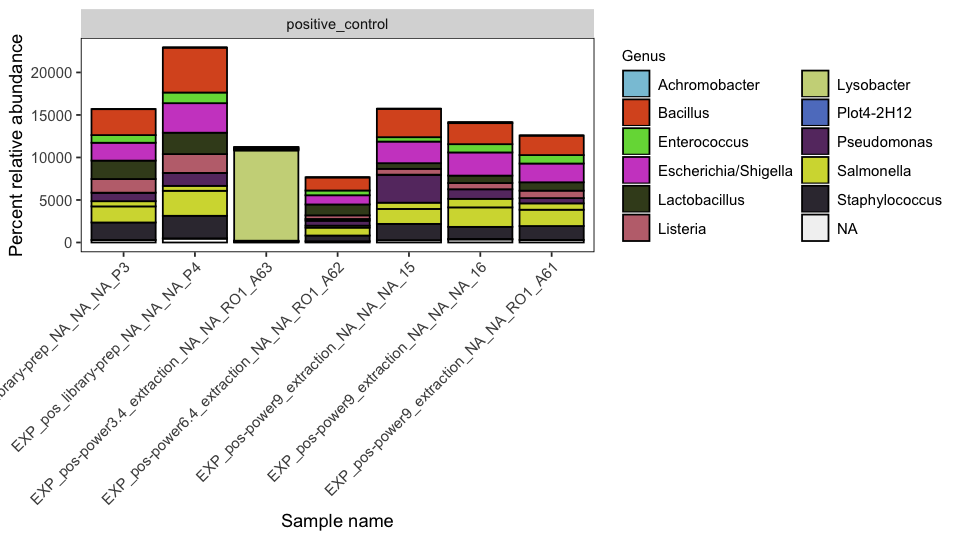

In [14]:
ps_mock <- subset_samples(ps_raw, subset = location_code %in% c("positive_control"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 10, TRUE) #keep only seqs that had reads in mock(s)

options(repr.plot.width = 8, repr.plot.height = 4.5)

plot_bar(ps_mock, x="sample_code_full_and_batch", fill="Genus") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

**A61, A62, and A63 were extraction controls with 10^9, 10^6, and 10^3 cells input, respectively.**

In [15]:
#make table of mock sequences
ps_mock <- subset_samples(ps, subset = location_code %in% c("positive_control"))
ps_mock <- filter_taxa(ps_mock, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads in mock(s)
mock_tax <- as.data.frame(tax_table(ps_mock))
mock_otu <- as.data.frame(otu_table(ps_mock))
mock_otu <- t(mock_otu)
mock_tab <- merge(mock_otu, mock_tax, by=0)
row.names(mock_tab) <- mock_tab$Row.names
mock_tab <- subset(mock_tab, select = -c(Row.names))
mock_tab <- mock_tab[order(-mock_tab$SD039), ] # sort in descending order
head(mock_tab)
mock_seqs <- row.names(mock_tab)
#mock_seqs <- as.data.frame(refseq(ps_mock))
#merge(mock_tab, mock_seqs, by.x="Row.names", by.y=names)

SD037
AGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 3054 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA 2100 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA 1892 
AGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGAAAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGCAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACGCTGATGTGCGAAAGCGTGGGGATCAAACA 2055 
AGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA  898 
AGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGAGTGCAGGCGGTTTTCTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGAAGTGCATCGGAAACTGGATAACTTGAGTGCAGAAGAGGGTAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTACCTGGTCTGCAACTGACGCTGAGACTCGAAAGCATGGGTAGCGAACA 2167 
                                                                                                                                                                                                                                                       SD039
AGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 2299 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA 2207 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA 1920 
AGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGAAAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGCAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACGCTGATGTGCGAAAGCGTGGGGATCAAACA 1632 
AGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA  993 
AGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGAGTGCAGGCGGTTTTCTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGAAGTGCATCGGAAACTGGATAACTTGAGTGCAGAAGAGGGTAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTACCTGGTCTGCAACTGACGCTGAGACTCGAAAGCATGGGTAGCGAACA  984 
                                                                                                                                                                                                                                                       SD049
AGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 110  
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCC

In [16]:
# load reference sequences for mock controls and compare:
mock.ref <- getSequences("~/data/refs/ZymoBIOMICS.STD.refseq.v2/ssrRNAs/zymo_mock_16S_18S.fasta")
# identify matches to references, anything else is contamination
match.ref <- sapply(mock_seqs, function(x) any(grepl(x, mock.ref)))
match.ref <- as.data.frame(match.ref)

In [17]:
mock_tab <- merge(mock_tab, match.ref, by=0)
row.names(mock_tab) <- mock_tab$Row.names
mock_tab <- subset(mock_tab, select = -c(Row.names))
mock_tab <- mock_tab[order(-mock_tab$SD039), ] # sort in descending order

In [18]:
mock_tab

SD037
AGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA 3054 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA 2100 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA 1892 
AGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGAAAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGCAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACGCTGATGTGCGAAAGCGTGGGGATCAAACA 2055 
AGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA  898 
AGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGAGTGCAGGCGGTTTTCTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGAAGTGCATCGGAAACTGGATAACTTGAGTGCAGAAGAGGGTAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTACCTGGTCTGCAACTGACGCTGAGACTCGAAAGCATGGGTAGCGAACA 2167 
AGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCGCGCAGGCGGTCTTTTAAGTCTGATGTGAAAGCCCCCGGCTTAACCGGGGAGGGTCATTGGAAACTGGAAGACTGGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA 1605 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA  610 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA 1004 
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGGAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA  298 
AGGATCCGAGCGTTGTCCGGAATTACTGGGTATAAAGGGTGCGTAGGCGGCTTTTTGCGTCAGAGGTGAAATCCACAGGCTCAACCTGTGGGGTGCCTTTGAAACGGGAAGGCTTGAGTATGACAGAGGCGGATGGAATTCCTGGTGTAGCAGTGAAATGCGTAGATATCAGGAGGAACACCGGTGGCGAAGGCGGTCCGCTGGGTCATAACTGACGCTGAGGCACGAAAGCGTGGGGATCAAACA    0 
AGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGGATTTTAAGTCAGCGGTGAAATTTTCAGGCTCAACCTGAACACTGCCGTTGAAACTGGGATTCTTGAGTATGGATGAAGTAGGCGGAATTCGTTGTGTAGCGGTGACATGCTTAGATATAACGAGGAACTCCGATTGCGTAGGCAGCTTACTAAGCCATAACTGACGCTCAAGCACGAAAGCGTGGGGATCAAACA    0 
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCATTCAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGTTTGGCTTGAGACCGGAAGAGGTAAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTTACTGGTCCGGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA    2 
AGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGAGCGTAGGCGGACATTTAAGTCAGGGGTGAAATCCCAGAGCTCAACTCTGGAACTGCCTTTGATACTGGATGTCTTGAGTGTGAGAGAGGTATGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACATACTGGCTCATTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA    0 
AGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACATTTAAGTCAGGGGTGAAATCCCAGAGCTCAACTCTGGAACTGCCTTTGATACTGGGTGTCTAGAGTATGGAAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGTCCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA    0 
AGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCGGGGCTCAACCCCGGAATAGCCTTTAAGACTGCATCGCTTGAACGTCGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTC

**There is a Salmonella enterica ASV (one mismatch) that isn't in the ref sequences and is abundant in all mock controls (except SD049, which failed).** Similarly, the Zymo mock community we sequenced with the El Paso study also had a Salmonella ASV that didn't match to the reference sequence (1 nt mismatch). It was a different one from this one though. Perhaps this is variable in Zymo's stock or there is error during PCR of this sequence (or sequencing error not corrected by DADA2).  This was also observed by Karsten et al. 2019.

In [19]:
# collect all mock taxa to remove them later
mock_taxa <- row.names(mock_tab[1:10,])

# Negative controls and overlaps with samples

## Collect sets of taxa, identify taxa found in both blanks and samples for further investigation

In [20]:
ps_samp <- subset_samples(ps, subset = !(location_code %in% c("negative_control",
                                                              "field_blank",
                                                              "RO_BF_control",
                                                              "positive_control")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps, subset = location_code %in% c("negative_control", "field_blank", "RO_BF_control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_samp_blank <- subset_samples(ps, subset = !(location_code %in% c("positive_control")))
ps_samp_blank <- filter_taxa(ps_samp_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7052 taxa and 171 samples ]
sample_data() Sample Data:       [ 171 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7052 taxa by 7 taxonomic ranks ]

In [21]:
blank_taxa <- taxa_names(ps_blank)
samp_taxa <- taxa_names(ps_samp)
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

In [22]:
length(samp_only_taxa)

[1] 6783

## Plot intersecting taxa (found in blanks and samples)

In [23]:
#for plotting, get intersecting taxa, include mocks
ps_intersecting <- prune_taxa(intersecting_taxa, ps)
ps_intersecting

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 185 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 185 taxa by 7 taxonomic ranks ]

In [24]:
# normalize to percent
ps_perc <- transform_sample_counts(ps, function(OTU) 100*OTU/sum(OTU))
#
ps_intersecting_perc <- prune_taxa(intersecting_taxa, ps_perc)
ps_intersecting_perc <- filter_taxa(ps_intersecting_perc, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads
ps_intersecting_perc_filt5 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 5)), TRUE)
ps_intersecting_perc_filt2 <- filter_taxa(ps_intersecting_perc, filterfun(kOverA(2, 2)), TRUE)

In [25]:
ps_intersecting_perc_filt2
ps_intersecting_perc_filt5

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 53 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 53 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 41 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 41 taxa by 7 taxonomic ranks ]

**Major contaminants are clostridiaceae_1, peptostreptococcaceae, and Family XI, Xanthomonadaceae**

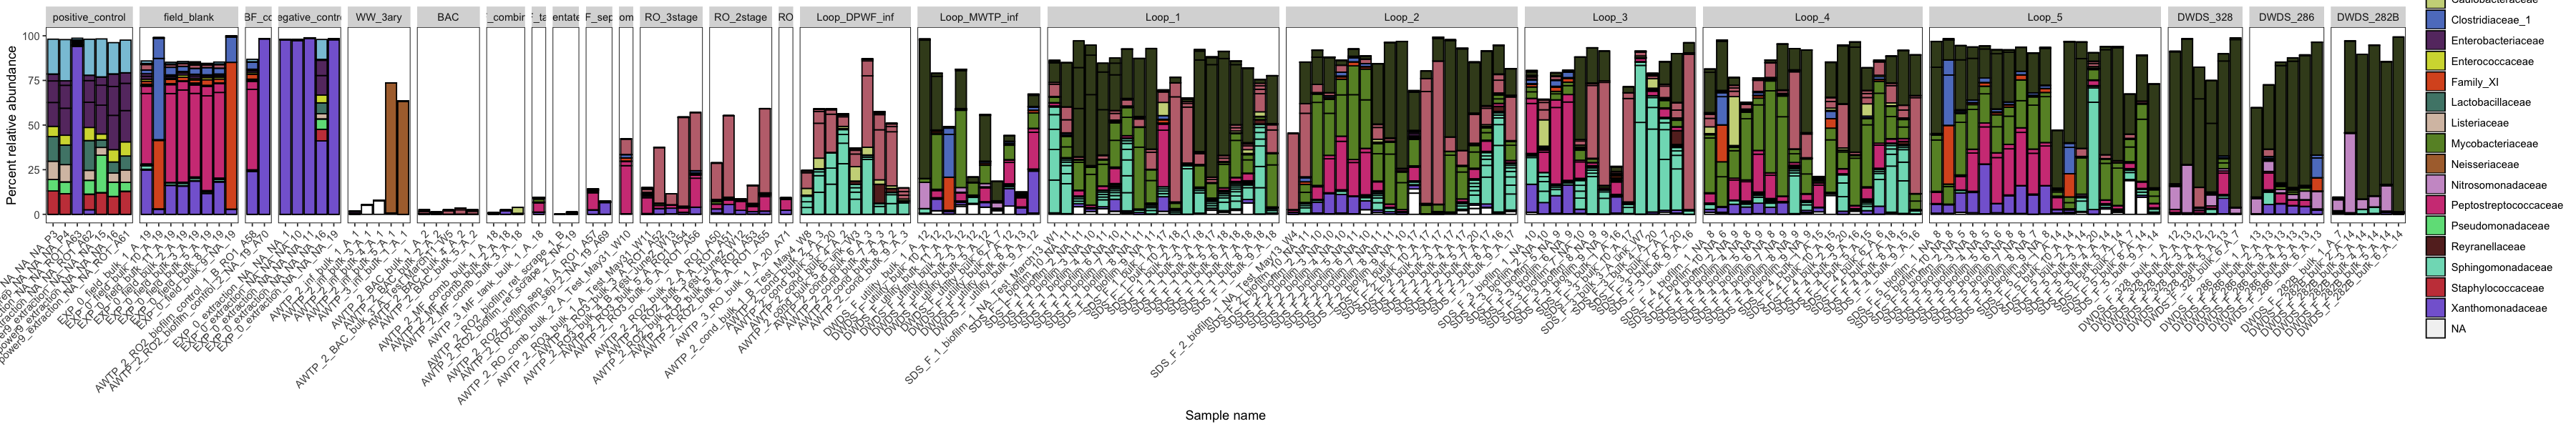

In [37]:
options(repr.plot.width = 30, repr.plot.height = 5)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_intersecting_perc_filt5, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    #facet_wrap(~location_code, nrow=4, scale="free_x")
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=1))
ggsave('~/data/awtp2_16S/barplot_intersction_samples_blanks_gr5perc_genus.png', device='png', width=30, height=5)

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

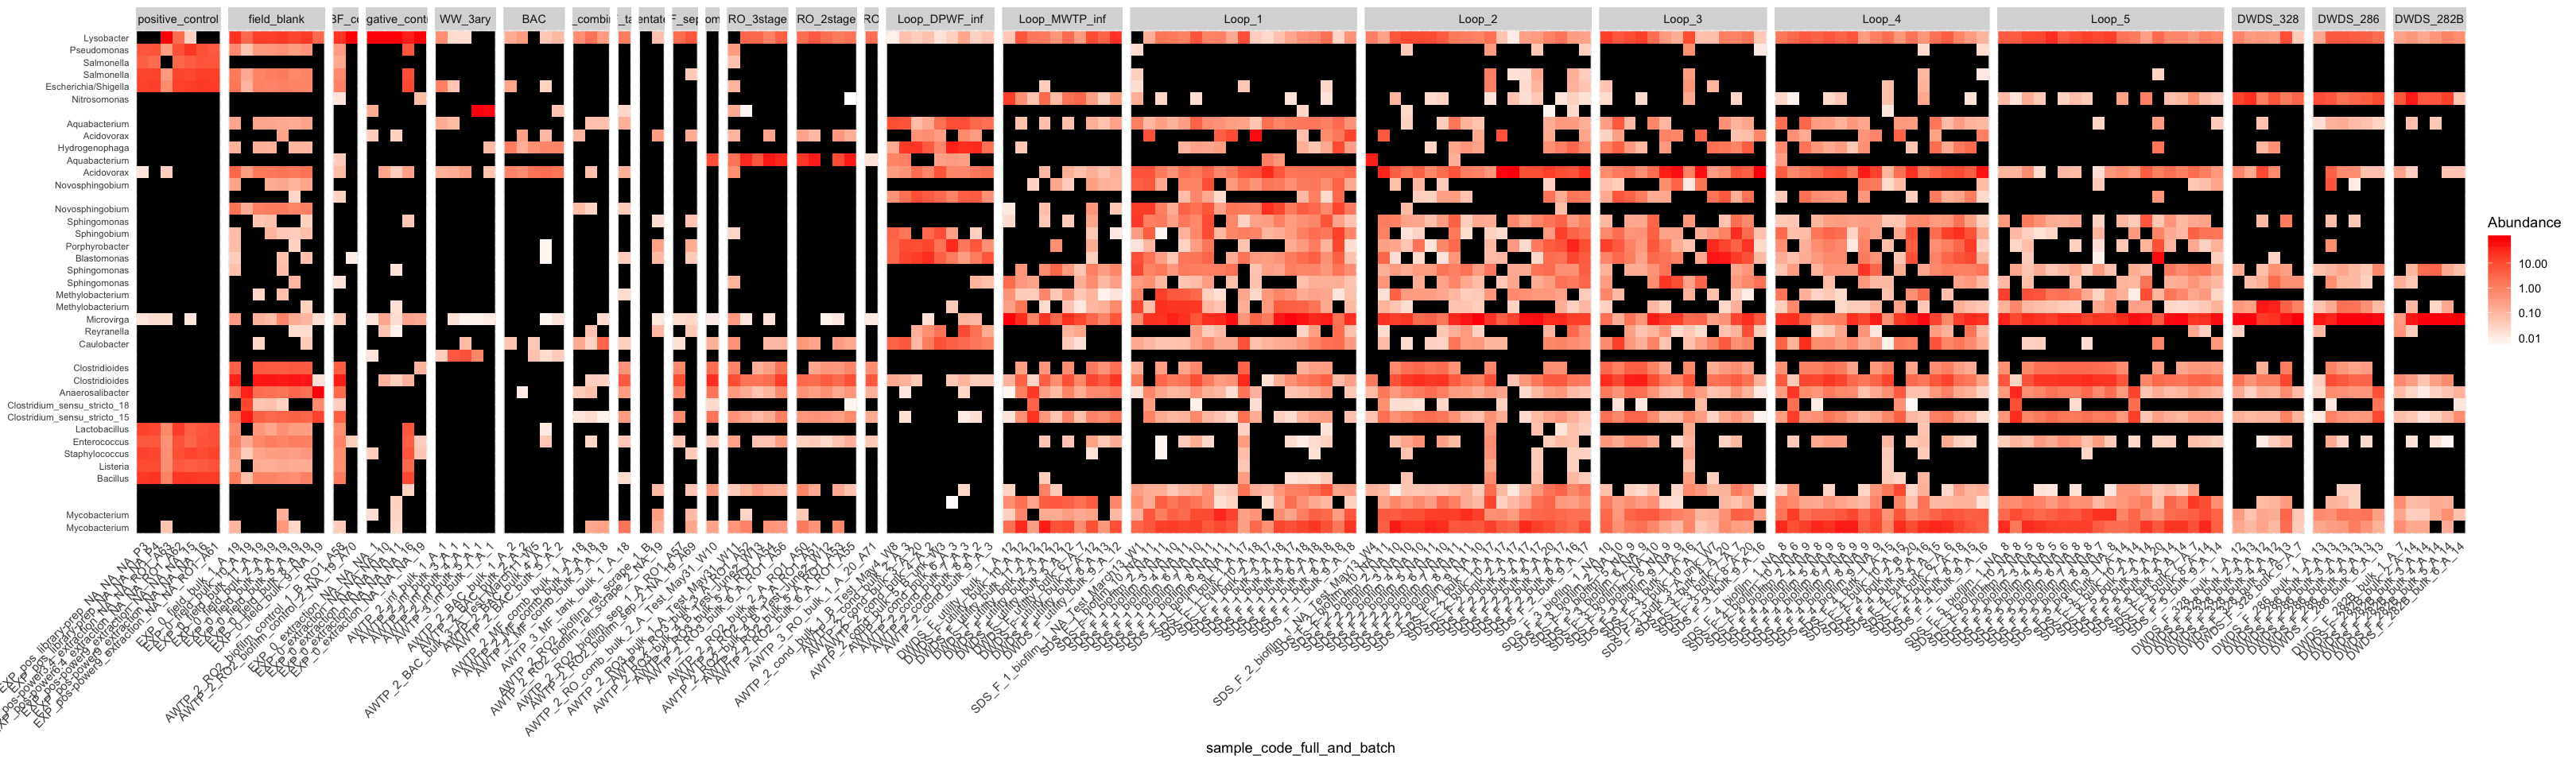

In [33]:
#plot heatmap
options(repr.plot.width = 27, repr.plot.height = 8)
plot_heatmap(ps_intersecting_perc_filt5, taxa.label = "Genus", sample.label = "sample_code_full_and_batch", sample.order = "sample_code_full_and_batch", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
ggsave('~/data/awtp2_16S/heatmap_intersction_samples_blanks_gr5perc_genus.png', device='png', width=30, height=9)

## Cross-contamination coming from positive control into samples/blanks

Warning message:
“Transformation introduced infinite values in discrete y-axis”

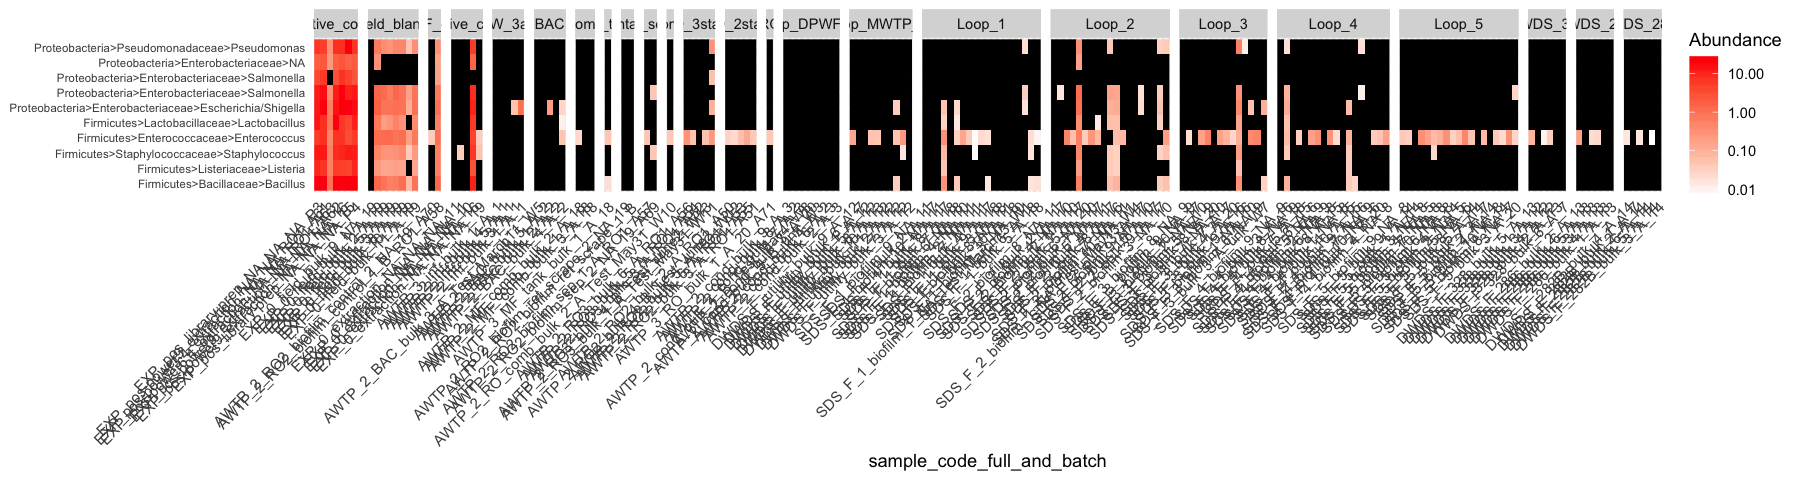

In [202]:
ps_mock_in_all_perc <- prune_taxa(mock_taxa, ps_perc)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 4)
plot_heatmap(ps_mock_in_all_perc, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_mock_in_all.png', device='png', width=20, height=4)

**E. facaelis appears to be a broader cross-contaminant than just part of the mock, since it is found in the absense of the other mock ASVs, but only in low biomass samples.**

# Decontamination

In [203]:
length(blank_taxa)
length(samp_taxa)
length(intersecting_taxa)

[1] 269

[1] 6968

[1] 185

In [204]:
#for decontamination: Get all taxa found in samples, include blanks in ps object.
#ps_samp_blank_for_decontam <- prune_taxa(samp_taxa, ps_samp_blank)
ps_samp_blank_for_decontam <- ps_samp_blank
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7052 taxa and 171 samples ]
sample_data() Sample Data:       [ 171 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7052 taxa by 7 taxonomic ranks ]

## Remove mock taxa from dataset (including the E. facaelis that is present in some samples)

In [205]:
allTaxa = taxa_names(ps_samp_blank_for_decontam)
allTaxa_minus_mock <- allTaxa[!(allTaxa %in% mock_taxa)]
ps_samp_blank_for_decontam <- prune_taxa(allTaxa_minus_mock, ps_samp_blank_for_decontam)
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7042 taxa and 171 samples ]
sample_data() Sample Data:       [ 171 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7042 taxa by 7 taxonomic ranks ]

## Remove PCR negative control that is contaminated with mock taxa

In [206]:
#EXP_0_extraction_NA_NA_NA_16 = SD108 <- contaminated with mock taxa
#EXP_0_extraction_NA_NA_NA_4  <- contaminated with something else, has less than 7500 reads so is excluded already
ps_samp_blank_for_decontam <- subset_samples(ps_samp_blank_for_decontam, subset = !(sample_code_full_and_batch %in% c("EXP_0_extraction_NA_NA_NA_16")))

## Redefine intersecting taxa (found in blanks and samples) now that samples have been curated

In [207]:
ps_samp <- subset_samples(ps_samp_blank_for_decontam, subset = !(location_code %in% c("negative_control",
                                                              "field_blank",
                                                              "RO_BF_control",
                                                              "positive_control")))
ps_samp <- filter_taxa(ps_samp, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

ps_blank <- subset_samples(ps_samp_blank_for_decontam, subset = location_code %in% c("negative_control", "field_blank", "RO_BF_control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

blank_taxa <- taxa_names(ps_blank)
samp_taxa <- taxa_names(ps_samp)
intersecting_taxa <- intersect(samp_taxa, blank_taxa)
samp_only_taxa <- setdiff(samp_taxa, intersecting_taxa)
length(intersecting_taxa)

[1] 173

In [208]:
length(samp_only_taxa)

[1] 6785

## DESeq2-guided subtractive decontamination method

Note: the result is the same if ALL taxa from blanks are included and if only taxa in both blanks and samples are included

In [209]:
#set factor levels so "control" comes first
sample_data(ps_samp_blank_for_decontam)$sample_or_control <- factor(sample_data(ps_samp_blank_for_decontam)$sample_or_control, levels=c("control", "sample"))

In [210]:
ps_samp_blank_for_decontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7042 taxa and 170 samples ]
sample_data() Sample Data:       [ 170 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 7042 taxa by 7 taxonomic ranks ]

In [211]:
#run DESeq on all samples vs blanks
# following: https://bioconductor.org/packages/devel/bioc/vignettes/phyloseq/inst/doc/phyloseq-mixture-models.html

diagdds_full = phyloseq_to_deseq2(ps_samp_blank_for_decontam, ~ sample_or_control)

# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds_full), 1, gm_mean)
diagdds_full = estimateSizeFactors(diagdds_full, geoMeans = geoMeans)
diagdds_full = DESeq(diagdds_full, test="Wald", fitType="local")

res_full = results(diagdds_full, cooksCutoff = FALSE)
res_full = res_full[order(res_full$padj, na.last=NA), ]

converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1647 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [212]:
alpha = 0.01
sigtab_full = res_full[(res_full$padj < alpha), ]
sigtab_full = cbind(as(sigtab_full, "data.frame"), as(tax_table(ps_samp_blank_for_decontam)[rownames(sigtab_full), ], "matrix"))

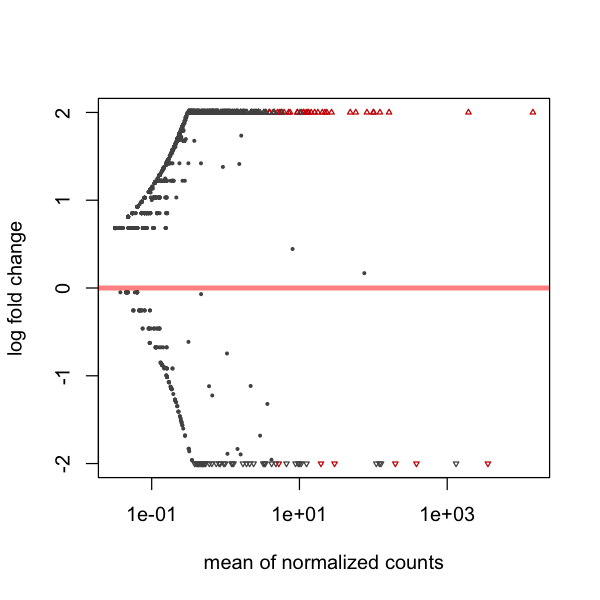

In [213]:
#plot deseq results
options(repr.plot.width = 5, repr.plot.height = 5)
plotMA(res, ylim=c(-2,2))

In [214]:
significant_taxa_full <- row.names(sigtab_full[sigtab_full$log2FoldChange > 0,]) #what is significantly enriched in samples over blanks?

### Identify ASVs that were in both blanks and samples and were significantly enriched in samples

In [215]:
## Identify ASVs that were in both blanks and samples and were significantly enriched in samples
samples_over_blanks_full <- intersect(intersecting_taxa, significant_taxa_full)

## Identify ASVs that were in both blanks and samples and were not significantly enriched in samples (will be removed)
blanks_over_samples_full <- setdiff(intersecting_taxa, significant_taxa_full)
length(samples_over_blanks_full)
length(blanks_over_samples_full)

[1] 22

[1] 151

### Heatmaps of taxa to remove and taxa to keep

Warning message:
“Transformation introduced infinite values in discrete y-axis”

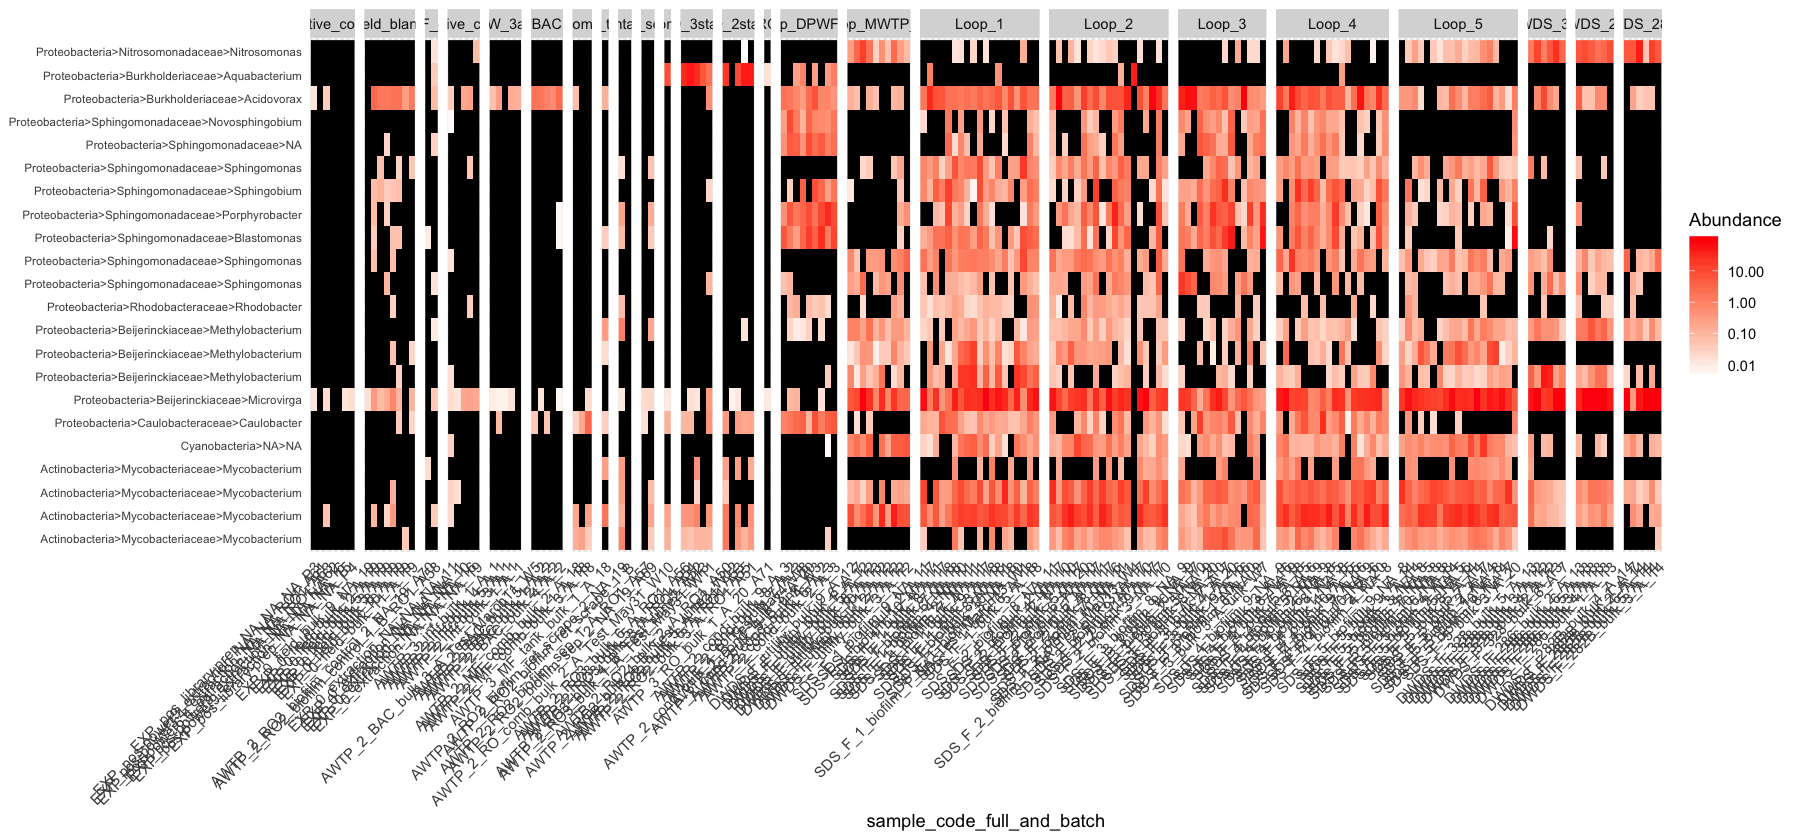

In [216]:
ps_perc_samples_over_blanks_full <- prune_taxa(samples_over_blanks_full, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 7)
plot_heatmap(ps_perc_samples_over_blanks_full, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_samples_over_blanks.png', device='png', width=20, height=4)

Warning message:
“Transformation introduced infinite values in discrete y-axis”

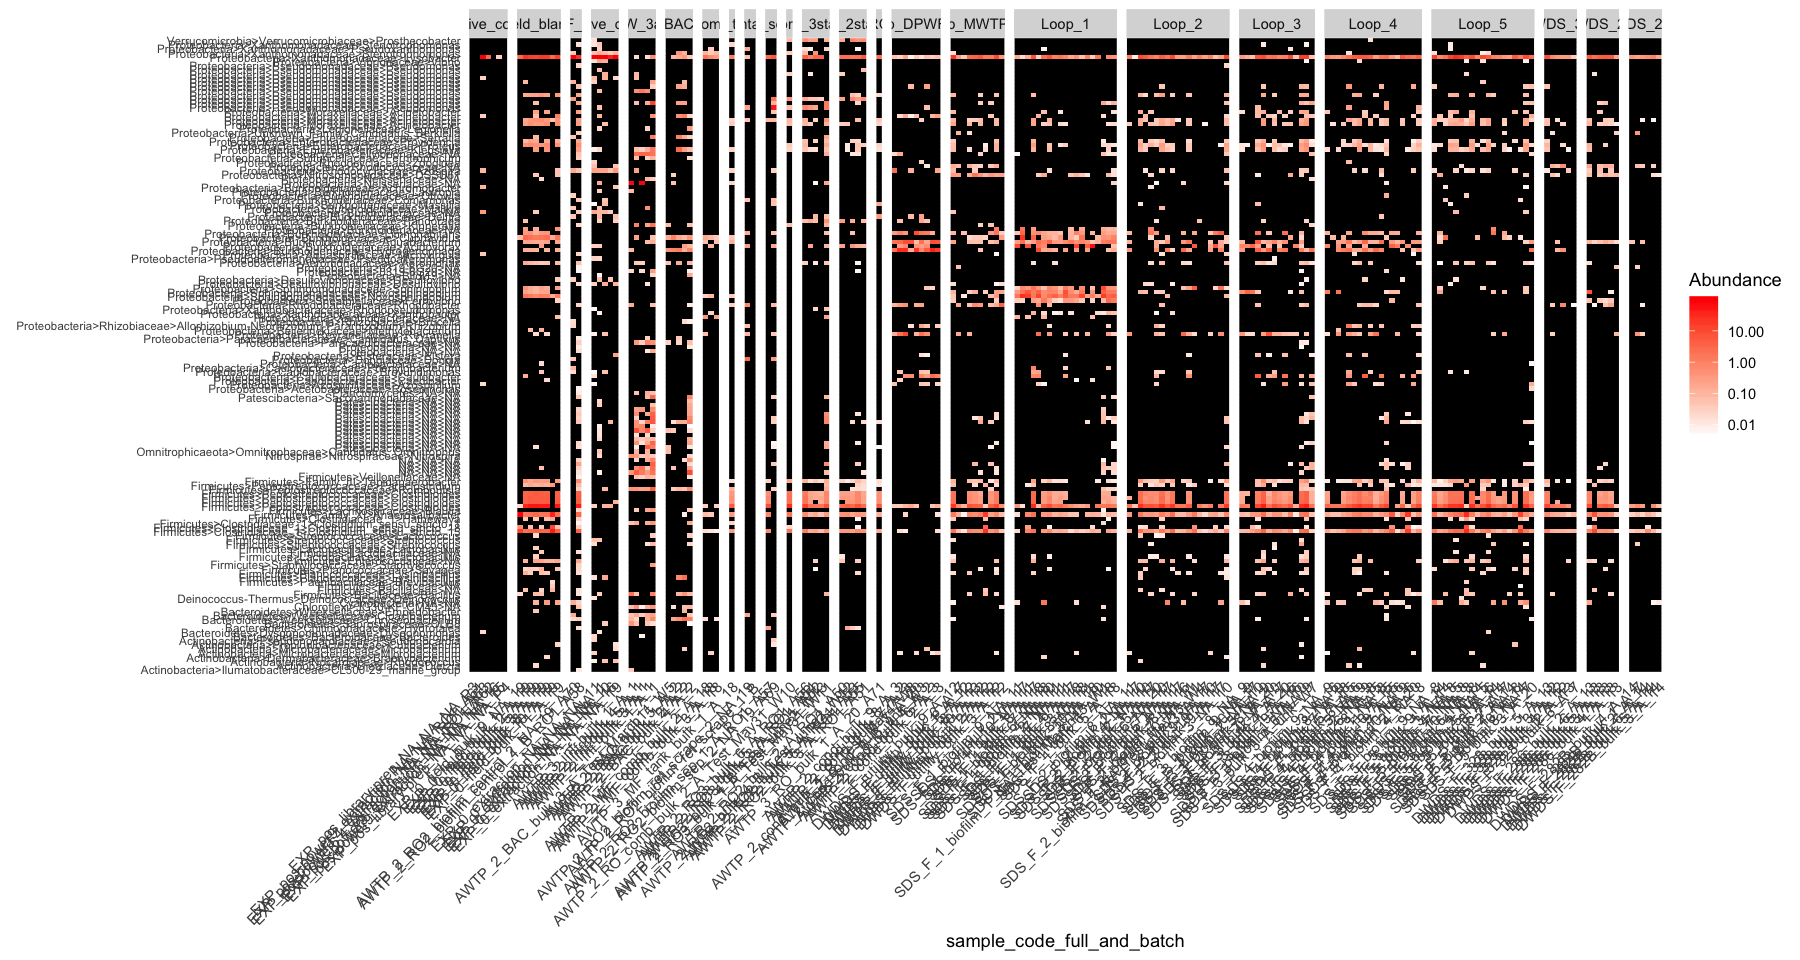

In [217]:
ps_perc_blanks_over_samples_full <- prune_taxa(blanks_over_samples_full, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 10)
plot_heatmap(ps_perc_blanks_over_samples_full, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_blanks_over_samples', device='png', width=25, height=15)

### Combine to get taxa from sample-only and taxa significant by DESeq, convert to relative abundance of remaining reads

In [218]:
ps_clean <- prune_taxa(taxa=union(significant_taxa, samp_only_taxa), ps)
sample_data(ps_clean)$filtered_readcounts <- sample_sums(ps_clean)
ps_clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

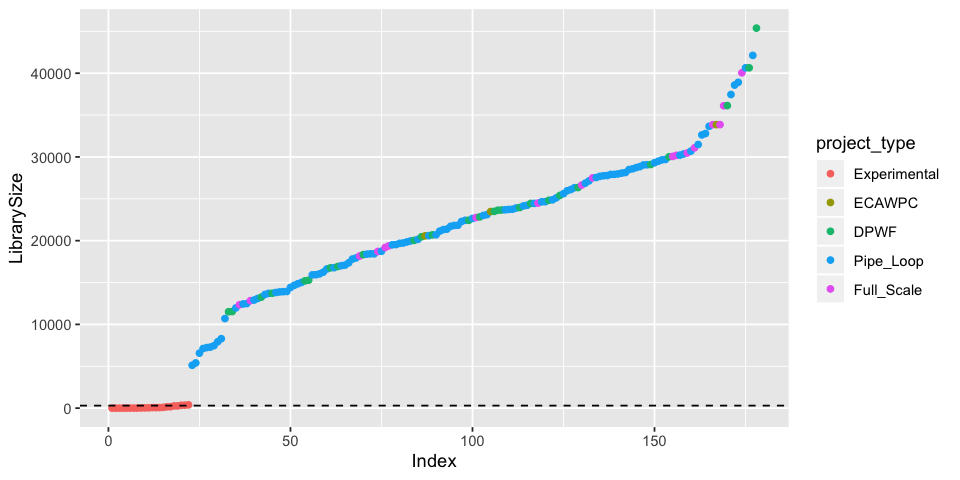

In [219]:
min_reads <- 300
df <- as.data.frame(sample_data(ps_clean)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_clean)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=project_type))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')

In [220]:
ps_clean_filt <- prune_samples(sample_sums(ps_clean)>=300, ps_clean) #remove samples now with too few reads
ps_clean_filt <- filter_taxa(ps_clean_filt, filterfun(kOverA(1, 0)), TRUE)
ps_clean_perc <- transform_sample_counts(ps_clean_filt, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_clean
ps_clean_filt
                                              
#saveRDS(ps_clean_filt, "~/data/awtp2_16S/ps_clean_filt.rds")
#saveRDS(ps_clean_perc, "~/data/awtp2_16S/ps_clean_perc.rds")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 159 samples ]
sample_data() Sample Data:       [ 159 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

## Trying DESeq2 Method on individual sample types

In [222]:
locations <- as.data.frame(table(sample_data(ps_samp_blank_for_decontam)$location_code))
colnames(locations)=c('location_code', 'count')
#locations[location$count>=]

In [223]:
#all sample types with >=3 samples
WW_3ary <- 'WW_3ary'
BAC <- 'BAC'
MF <- 'MF_combined'
RO <- c('RO_combined', 'RO_3stage', 'RO_2stage')
Loops <- c('Loop_1', 'Loop_2', 'Loop_3', 'Loop_4', 'Loop_5')
Loop_DPWF_inf <- 'Loop_DPWF_inf'
Loop_MWTP_inf <- 'Loop_MWTP_inf'
DWDS <- c('DWDS_328', 'DWDS_286', 'DWDS_282B')

types <- list(WW_3ary, BAC, MF, RO, Loops, Loop_DPWF_inf, Loop_MWTP_inf, DWDS)
types

[[1]]
[1] "WW_3ary"

[[2]]
[1] "BAC"

[[3]]
[1] "MF_combined"

[[4]]
[1] "RO_combined" "RO_3stage"   "RO_2stage"  

[[5]]
[1] "Loop_1" "Loop_2" "Loop_3" "Loop_4" "Loop_5"

[[6]]
[1] "Loop_DPWF_inf"

[[7]]
[1] "Loop_MWTP_inf"

[[8]]
[1] "DWDS_328"  "DWDS_286"  "DWDS_282B"

In [224]:
significant_taxa <- c()
for (i in types){
    ps_subset_blank <- subset_samples(ps_samp_blank_for_decontam, subset = location_code %in% c(i, "negative_control", "field_blank", "RO_BF_control"))

    #run DESeq 
    diagdds = phyloseq_to_deseq2(ps_subset_blank, ~ sample_or_control)

    # calculate geometric means prior to estimate size factors
    gm_mean = function(x, na.rm=TRUE){
      exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
    }
    geoMeans = apply(counts(diagdds), 1, gm_mean)
    diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
    diagdds = DESeq(diagdds, test="Wald", fitType="local")

    res = results(diagdds, cooksCutoff = FALSE)
    res = res[order(res$padj, na.last=NA), ]
    alpha = 0.01
    sigtab = res[(res$padj < alpha), ]
    sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_subset_blank)[rownames(sigtab), ], "matrix"))
    significant_taxa_subset <- row.names(sigtab[sigtab$log2FoldChange > 0,])
    significant_taxa <- c(significant_taxa, significant_taxa_subset)
}

converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 260 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 286 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
--

### Identify ASVs that were in both blanks and samples and were significantly enriched in samples

In [225]:
## Identify ASVs that were in both blanks and samples and were significantly enriched in samples
samples_over_blanks <- intersect(intersecting_taxa, significant_taxa)

## Identify ASVs that were in both blanks and samples and were not significantly enriched in samples (will be removed)
blanks_over_samples <- setdiff(intersecting_taxa, significant_taxa)
length(samples_over_blanks)
length(blanks_over_samples)

[1] 40

[1] 133

In [226]:
length(setdiff(samples_over_blanks, samples_over_blanks_full))

[1] 18

**This method identified all 22 of the significantly enriched taxa (samples_over_blanks) that were found when using the entire dataset for samples vs control.**

**This method also identified 18 additional significantly enriched taxa that were enriched in specific sample types over blanks.**

### Heatmaps of taxa to remove and taxa to keep

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

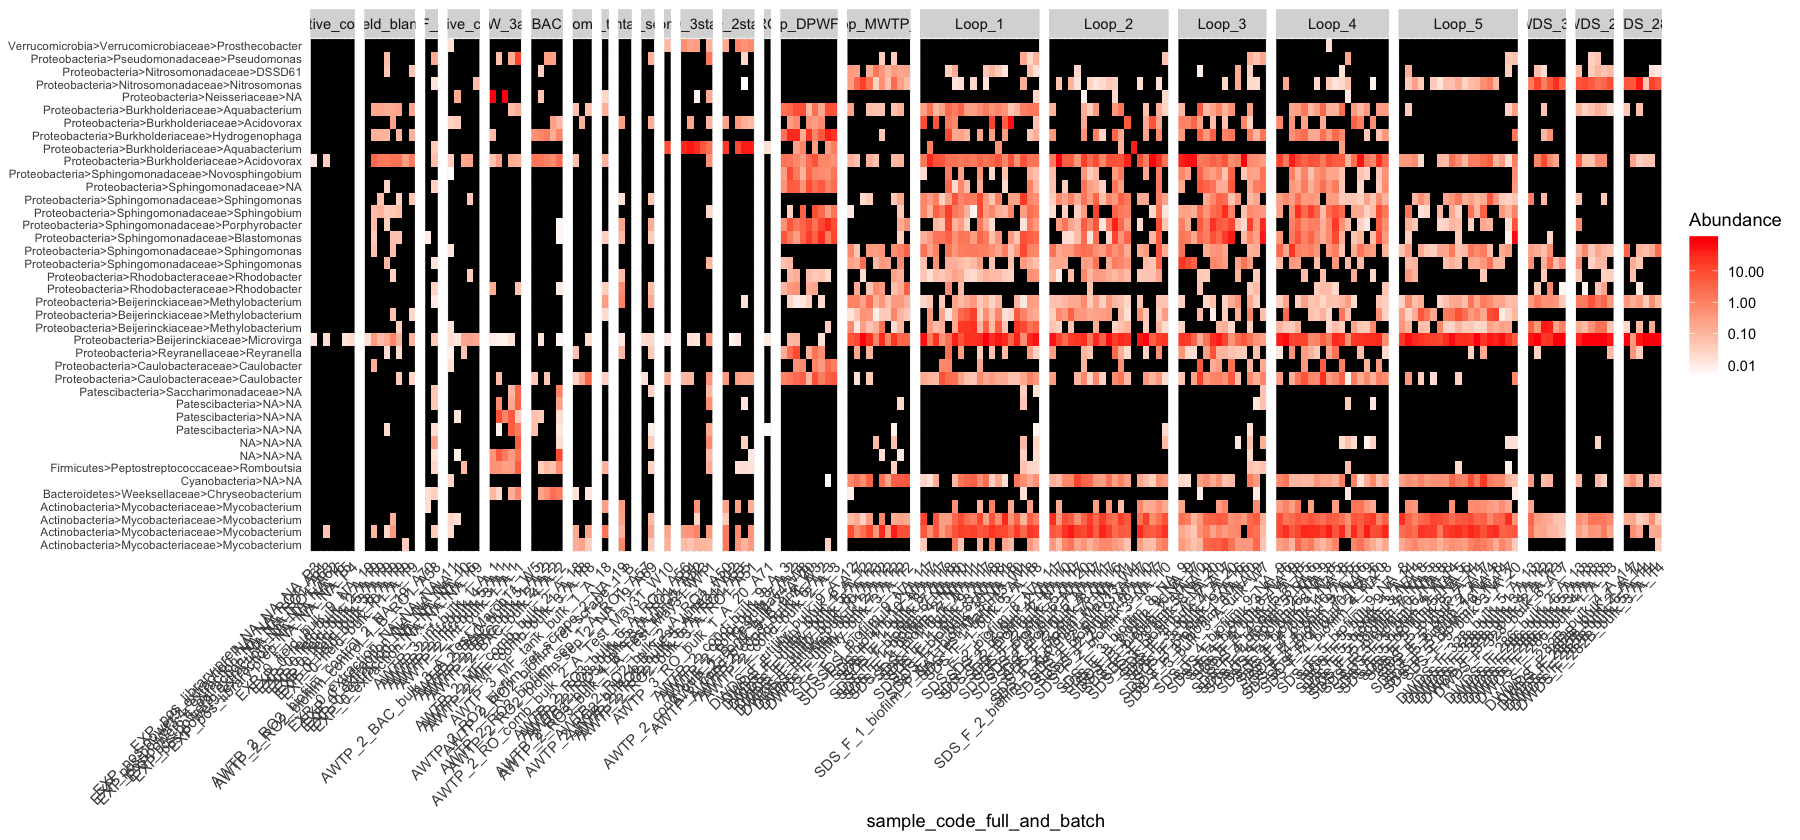

In [227]:
ps_perc_samples_over_blanks <- prune_taxa(samples_over_blanks, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 7)
plot_heatmap(ps_perc_samples_over_blanks, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_samples_over_blanks.png', device='png', width=20, height=7)

Warning message:
“Transformation introduced infinite values in discrete y-axis”Warning message:
“Transformation introduced infinite values in discrete y-axis”

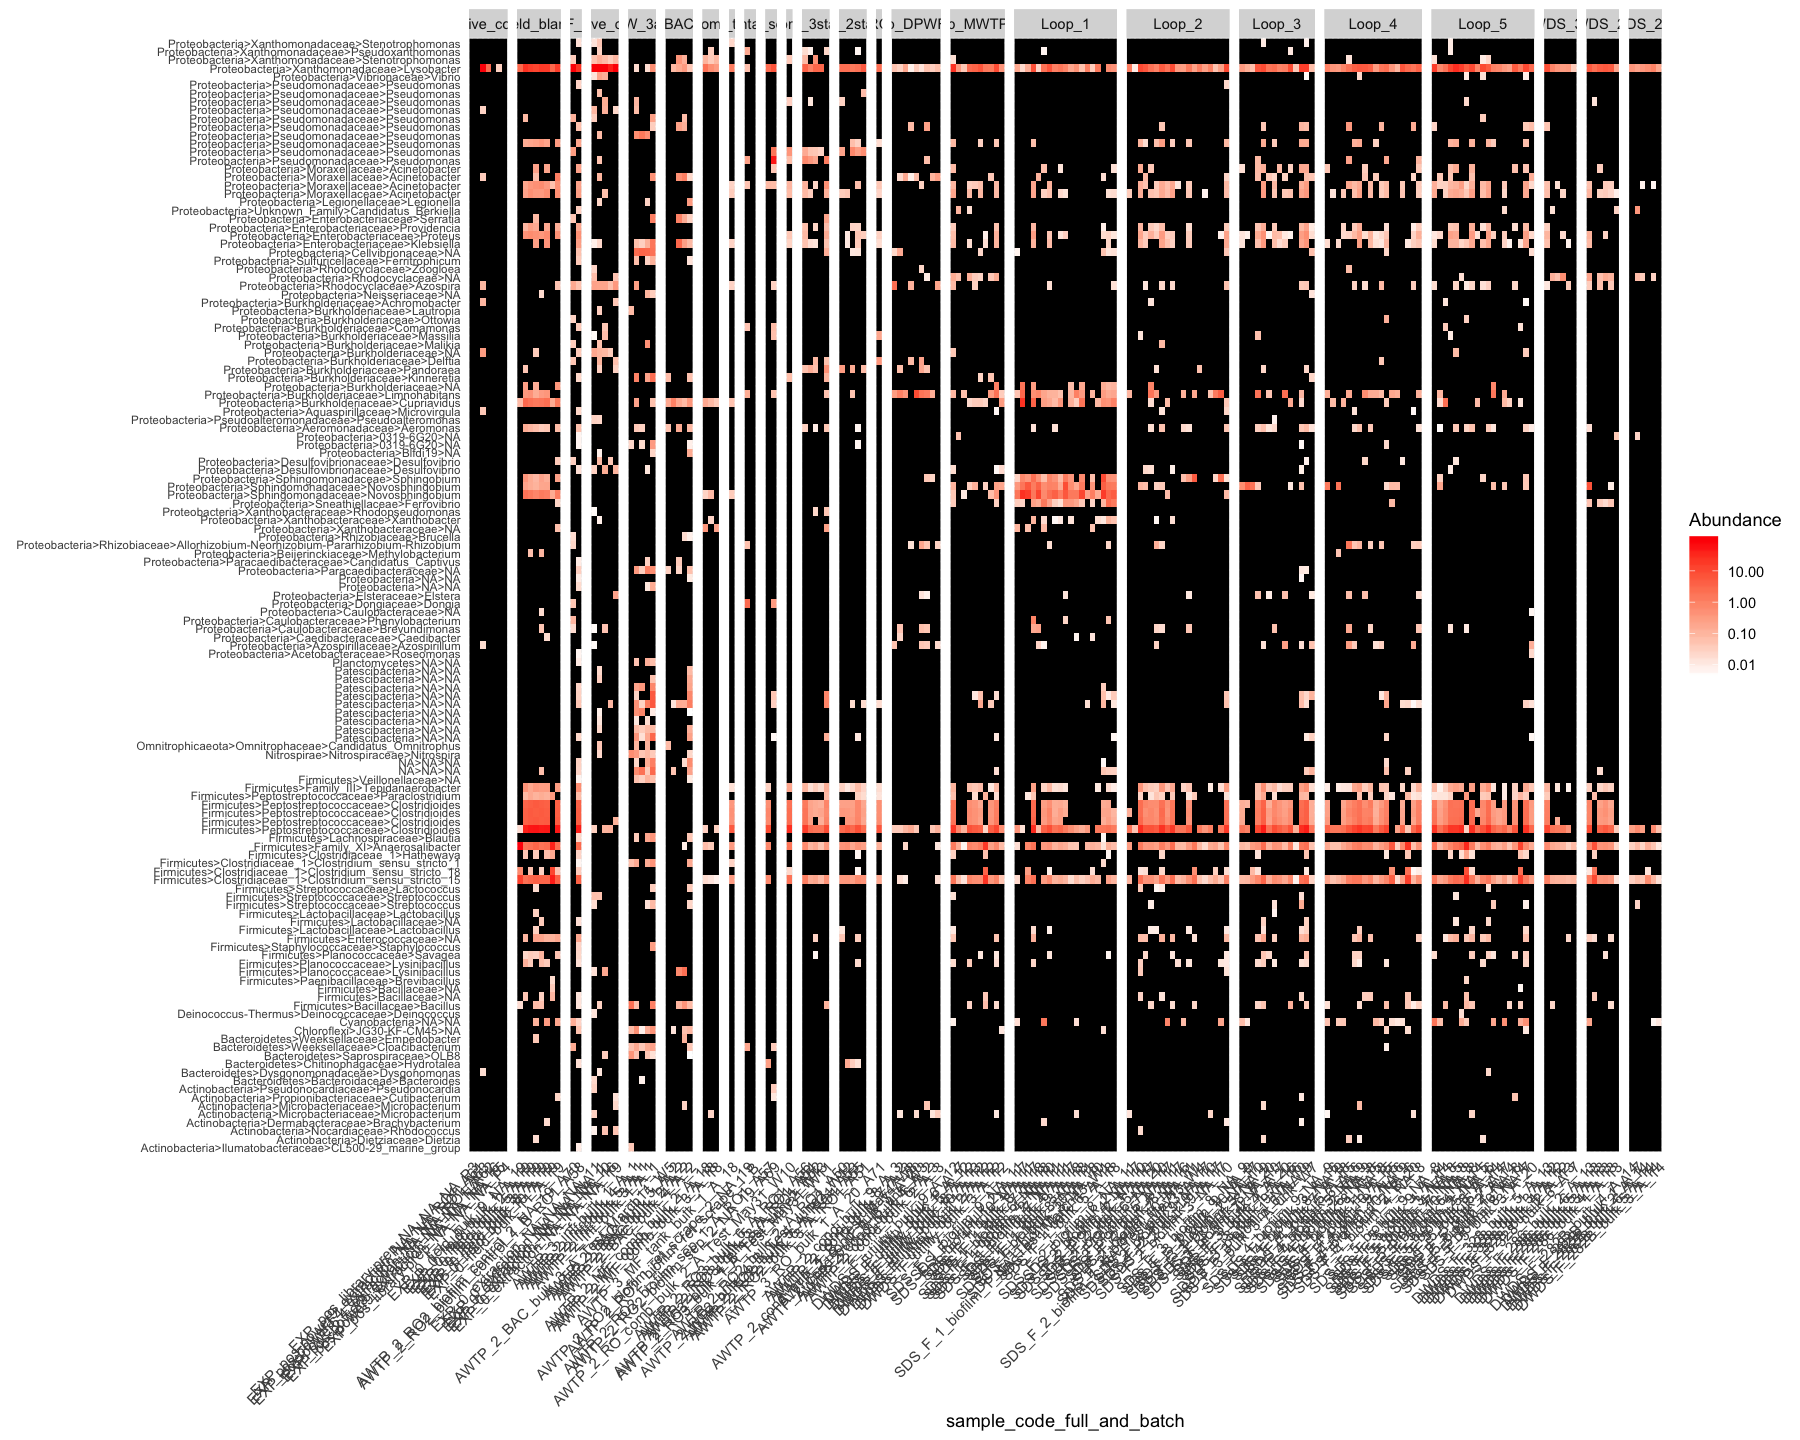

In [228]:
ps_perc_blanks_over_samples <- prune_taxa(blanks_over_samples, ps_perc)

options(repr.plot.width = 15, repr.plot.height = 12)
plot_heatmap(ps_perc_blanks_over_samples, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_blanks_over_samples.png', device='png', width=25, height=15)

### Combine to get taxa from sample-only and taxa significant by DESeq, convert to relative abundance of remaining reads

In [229]:
ps_clean <- prune_taxa(taxa=union(significant_taxa, samp_only_taxa), ps)
sample_data(ps_clean)$filtered_readcounts <- sample_sums(ps_clean)
ps_clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

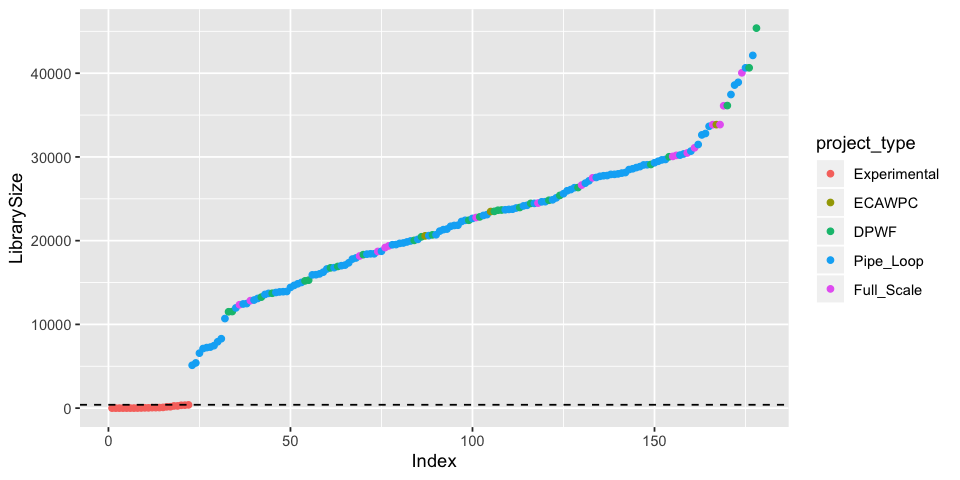

In [230]:
min_reads <- 400
df <- as.data.frame(sample_data(ps_clean)) # Put sample_data into a ggplot-friendly data.frame
df$LibrarySize <- sample_sums(ps_clean)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))

options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(data=df, aes(x=Index, y=LibrarySize, color=project_type))+
    geom_point()+
    geom_hline(yintercept = min_reads, linetype='dashed')

In [231]:
df[df$project_type=='Experimental',]

id_full    count_raw_reads barcode_forward barcode_reverse plate well
SD039 KNLK_SD039 37590           TACGAGAC        GTATGACG        1     D12 
SD114 KNLK_SD114 15543           ATATACAC        ATACTTCG        3     B2  
SD119 KNLK_SD119 44089           TGCGTACG        ATACTTCG        3     G2  
SD150 KNLK_SD150 43209           TACGAGAC        TCGAGCTC        4     D5  
SD001 KNLK_SD001 21320           TACGAGAC        GAGCTCAT        1     D2  
SD037 KNLK_SD037 44715           CGTTACTA        GTATGACG        1     B12 
SD167 KNLK_SD167 41907           TAGTGTAG        GTATGACG        6     H1  
SD045 KNLK_SD045 24666           ATATACAC        GAGCTCAT        2     B2  
SD049 KNLK_SD049 13221           ATATACAC        CTCTAGAG        2     B3  
SD109 KNLK_SD109 15763           CTAGAGCT        AAGTCGAG        3     D1  
SD117 KNLK_SD117 15805           GCTCTAGT        ATACTTCG        3     E2  
SD044 KNLK_SD044 27479           ACGACGTG        GAGCTCAT        2     A2  
SD107 KNLK_SD107 12957           ATATACAC        AAGTCGAG        3     B1  
SD108 KNLK_SD108 13415           CGTCGCTA        AAGTCGAG        3     C1  
SD002 KNLK_SD002 43792           CTACTATA        CTCTAGAG        1     A3  
SD120 KNLK_SD120 10477           TAGTGTAG        ATACTTCG        3     H2  
SD111 KNLK_SD111 10867           GACACTGA        AAGTCGAG        3     F1  
SD176 KNLK_SD176 40184           CTACTATA        GGTATGCT        8     A1  
SD116 KNLK_SD116 13830           CTAGAGCT        ATACTTCG        3     D2  
SD110 KNLK_SD110 10335           GCTCTAGT        AAGTCGAG        3     E1  
SD112 KNLK_SD112 21767           TGCGTACG        AAGTCGAG        3     G1  
SD113 KNLK_SD113 13749           ACGACGTG        ATACTTCG        3     A2  
      metagenomic_sample sample_code_full_and_batch                sample_date
SD039 N                  EXP_pos-power9_extraction_NA_NA_RO1_A61   NA         
SD114 N                  EXP_pos-power6.4_extraction_NA_NA_RO1_A62 NA         
SD119 N                  EXP_pos-power9_extraction_NA_NA_NA_16     NA         
SD150 Y                  EXP_pos-power9_extraction_NA_NA_NA_15     NA         
SD001 Y                  EXP_0_field_bulk_9_NA_19                  4/23/2018  
SD037 N                  EXP_pos_library-prep_NA_NA_NA_P3          NA         
SD167 N                  EXP_pos_library-prep_NA_NA_NA_P4          NA         
SD045 N                  AWTP_2_RO2_biofilm_control_2_NA_19_A70    8/9/2018   
SD049 N                  EXP_pos-power3.4_extraction_NA_NA_RO1_A63 NA         
SD109 N                  EXP_0_extraction_NA_NA_NA_19              NA         
SD117 N                  EXP_0_field_bulk_10_A_19                  4/26/2018  
SD044 N                  EXP_0_extraction_NA_NA_NA_1               NA         
SD107 N                  EXP_0_extraction_NA_NA_NA_10              NA         
SD108 N                  EXP_0_extraction_NA_NA_NA_16              NA         
SD002 Y                  EXP_0_extraction_NA_NA_NA_11              NA         
SD120 N                  EXP_0_field_bulk_11_A_19                  4/19/2018  
SD111 N                  EXP_0_field_bulk_2_A_19                   1/8/2018   
SD176 Y                  AWTP_2_RO2_biofilm_control_1_B_RO1_A58    1/10/2018  
SD116 N                  EXP_0_field_bulk_8_A_19                   3/26/2018  
SD110 N                  EXP_0_field_bulk_1_A_19                   12/29/2017 
SD112 N                  EXP_0_field_bulk_5_A_19                   3/5/2018   
SD113 N                  EXP_0_field_bulk_3_A_19                   2/15/2018  
      batch_sample_date ⋯ Ext_batch Extraction_Date Ext_num_unique
SD039 NA                ⋯ RO1       9/13/18         A61           
SD114 NA                ⋯ RO1       9/13/18         A62           
SD119 NA                ⋯ 16        8/30/18         148           
SD150 NA                ⋯ 15        8/28/18         142           
SD001 4/23/2018         ⋯ 19        9/8/18          183           
SD037 NA                ⋯ P3        1  

In [232]:
ps_clean_filt <- prune_samples(sample_sums(ps_clean)>=400, ps_clean) #remove samples now with too few reads
ps_clean_filt <- filter_taxa(ps_clean_filt, filterfun(kOverA(1, 0)), TRUE)
ps_clean_perc <- transform_sample_counts(ps_clean_filt, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_clean
ps_clean_filt                                            

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

In [ ]:
saveRDS(ps_clean_filt, "~/data/awtp2_16S/ps_clean_filt.rds")
saveRDS(ps_clean_perc, "~/data/awtp2_16S/ps_clean_perc.rds")

## Decontam frequency method

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

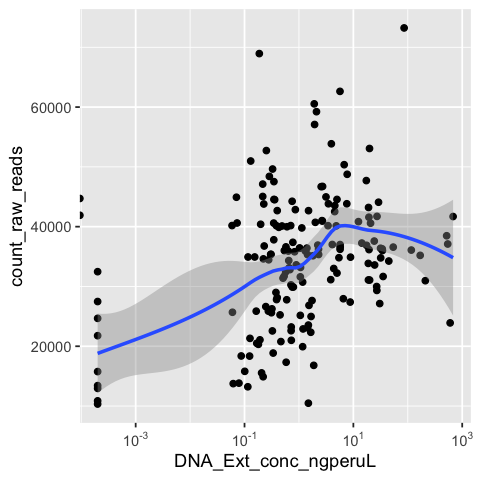

In [49]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(sample_data(ps), aes(x=DNA_Ext_conc_ngperuL, y=count_raw_reads))+
    geom_point()+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x))) + 
    geom_smooth(method = loess) 
    #scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))


In [50]:
contamdf.freq <- isContaminant(ps_samp, method="frequency", conc="DNA_Ext_conc_ngperuL", threshold = .1)

In [51]:
table(contamdf.freq$contaminant)
head(which(contamdf.freq$contaminant))


FALSE  TRUE 
 6880    78 

[1]   5   6  26 106 459 573

In [52]:
decontam_freq_contams <- row.names(contamdf.freq[contamdf.freq$contaminant==TRUE,])

In [53]:
decontam_freq_intersect <- intersect(decontam_freq_contams, intersecting_taxa)

**The decontam frequency method identified 4 ASVs that were part of the intersection of negative controls and samples.**

Warning message:
“Transformation introduced infinite values in discrete y-axis”

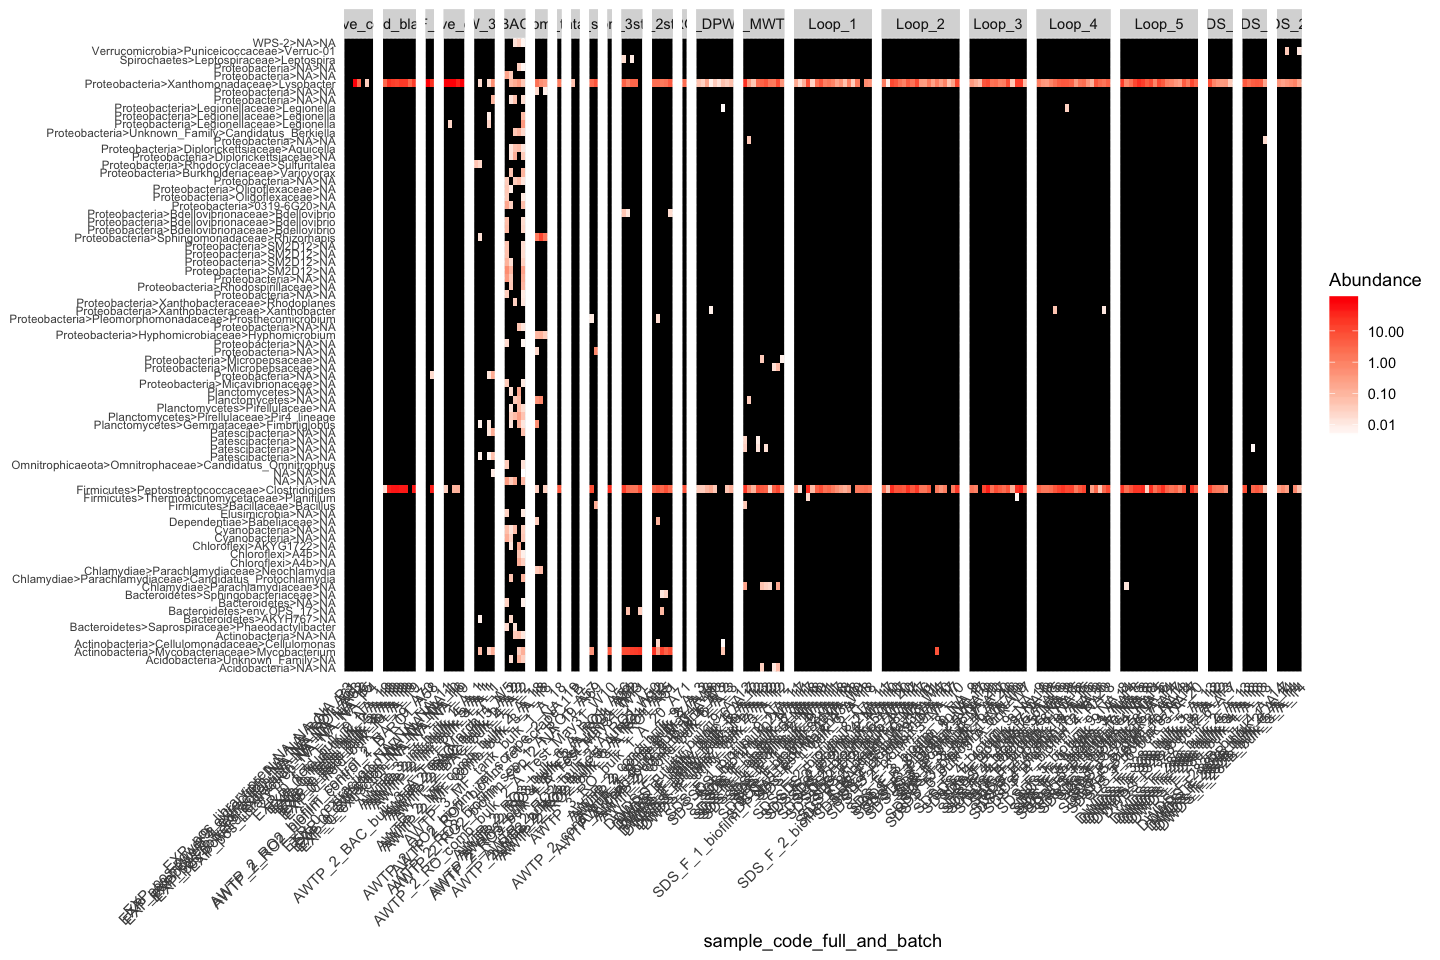

In [54]:
ps_decontam_freq_contams <- prune_taxa(decontam_freq_contams, ps_perc)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_freq_contams, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_contams.png', device='png', width=20, height=9)

## Decontam prevalence method

### Make dataset containing only samples and field blanks. The field blanks contain the contaminants from both extraction and field, so they are more comprehensive and consistent.

In [155]:
ps_blank <- subset_samples(ps_samp_blank_for_decontam, subset = location_code %in% c("negative_control", "field_blank", "RO_BF_control"))
ps_blank <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 253 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 253 taxa by 7 taxonomic ranks ]

In [156]:
#one of the RO_BF_control underwent flocculation while the other didn't.  So one should be treated like a "field blank" and the other like an "extraction blank"
ps_RO_BF_control <- subset_samples(ps_samp_blank_for_decontam, subset = (location_code %in% c("RO_BF_control")))
sample_data(ps_RO_BF_control)
#SD176 from 1/10/18 was flocculated
#SD045 from 8/9/2018 was not flocculated (shipped by collaborators)

id_full    count_raw_reads barcode_forward barcode_reverse plate well
SD045 KNLK_SD045 24666           ATATACAC        GAGCTCAT        2     B2  
SD176 KNLK_SD176 40184           CTACTATA        GGTATGCT        8     A1  
      metagenomic_sample sample_code_full_and_batch             sample_date
SD045 N                  AWTP_2_RO2_biofilm_control_2_NA_19_A70 8/9/2018   
SD176 Y                  AWTP_2_RO2_biofilm_control_1_B_RO1_A58 1/10/2018  
      batch_sample_date ⋯ location_code sample_type sampler_name Ext_batch
SD045 NA                ⋯ RO_BF_control biofilm     Rose_Kantor  19       
SD176 NA                ⋯ RO_BF_control biofilm     Rose_Kantor  RO1      
      Extraction_Date Ext_num_unique Microconcentrated. DNA_Ext_conc_ngperuL
SD045 9/27/18         A70            N                  0.0002              
SD176 9/13/18         A58            Y                  0.0590              
      kit           id   
SD045 NA            SD045
SD176 Powersoil Pro SD176

In [157]:
samp_names <- sample_names(ps_samp)
ext_blanks <- sample_names(subset_samples(ps_samp_blank_for_decontam, subset = (location_code %in% c("negative_control"))))
ext_blanks <- c(ext_blanks, 'SD045')
field_blanks <- sample_names(subset_samples(ps_samp_blank_for_decontam, subset = (location_code %in% c("field_blank"))))
field_blanks <- c(field_blanks, 'SD176')
#drop 2 inconsistent field blanks: EXP_0_field_bulk_10_A_19 and EXP_0_field_bulk_9_NA_19 from field_blanks c('SD001', 'SD117')
field_blanks <- setdiff(field_blanks, c('SD001', 'SD117'))
ps_samp_blank_for_decontam.field <- prune_samples(c(samp_names, field_blanks), ps_samp_blank_for_decontam)
ps_samp_blank_for_decontam.field <- filter_taxa(ps_samp_blank_for_decontam.field, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_samp_blank_for_decontam.field

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6998 taxa and 163 samples ]
sample_data() Sample Data:       [ 163 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 6998 taxa by 7 taxonomic ranks ]

In [158]:
sample_data(ps_samp_blank_for_decontam.field)$is.neg <- sample_data(ps_samp_blank_for_decontam.field)$sample_or_control == "control"
contamdf.prev <- isContaminant(ps_samp_blank_for_decontam.field, method="prevalence", neg="is.neg", threshold = .1)
table(contamdf.prev$contaminant)


FALSE  TRUE 
 6947    51 

In [159]:
decontam_prev_contams <- row.names(contamdf.prev[contamdf.prev$contaminant==TRUE,])

Warning message:
“Transformation introduced infinite values in discrete y-axis”

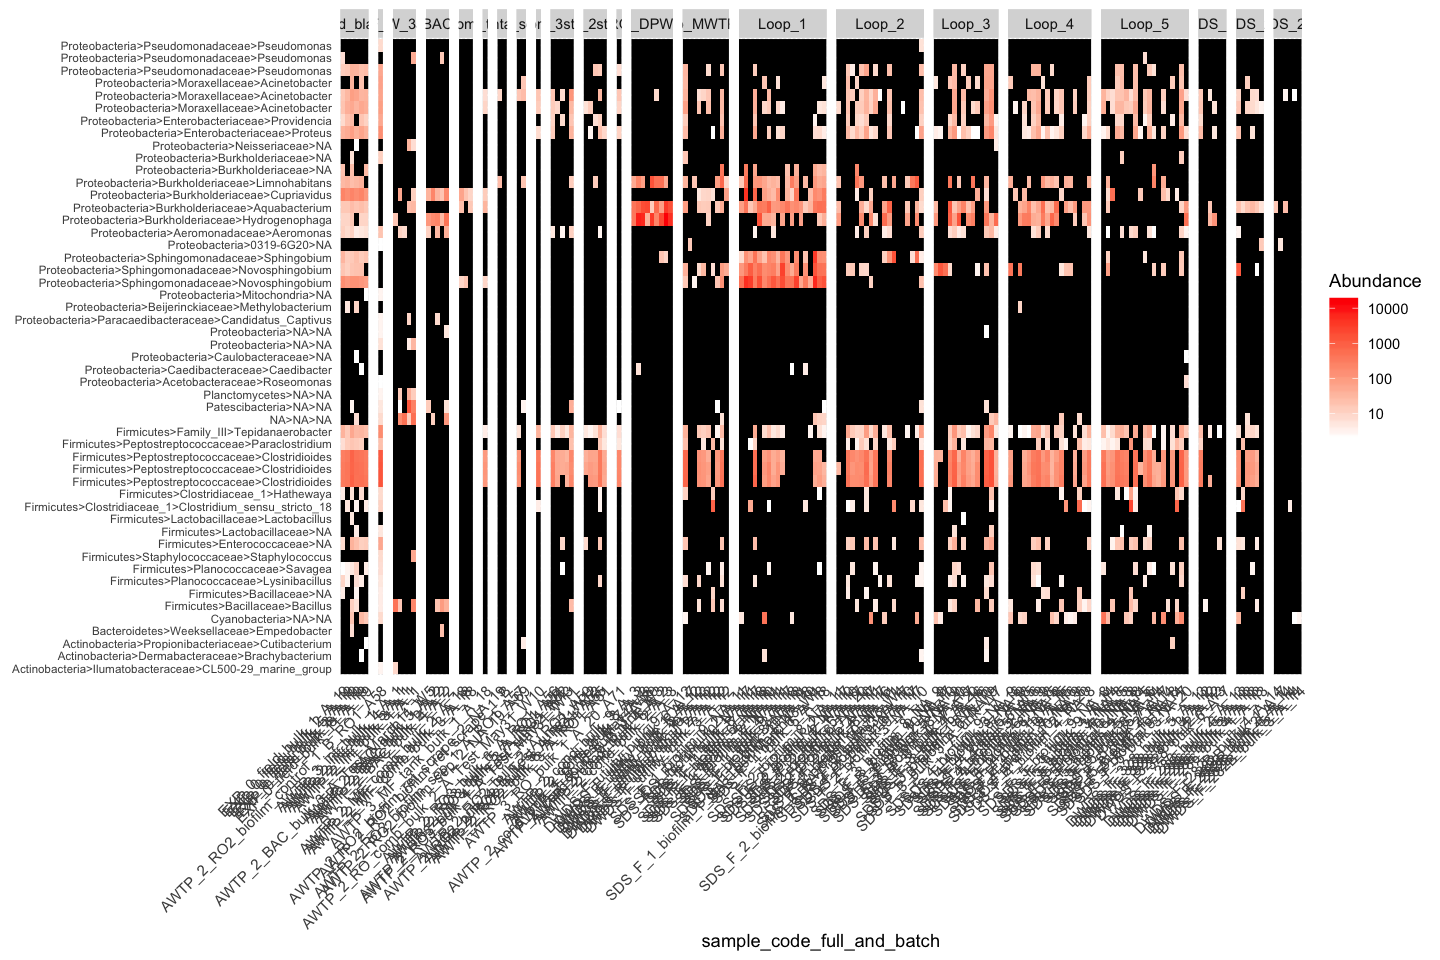

In [160]:
ps_decontam_prev_contams <- prune_taxa(decontam_prev_contams, ps_samp_blank_for_decontam.field)

#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_decontam_prev_contams, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_prev_contams.png', device='png', width=20, height=9)

**The `decontam` prevalence method identified as contaminants 47 of the 133 taxa removed by DESeq2-guided subtractive decontamination.**

In [161]:
length(intersect(decontam_prev_contams, blanks_over_samples))
length(blanks_over_samples)

[1] 47

[1] 133

In [162]:
decontam_not_deseq <- setdiff(decontam_prev_contams, blanks_over_samples)


**Prevalence won't work perfectly because it will miss contaminants that are present in ALL samples, so the best approach would be to combine frequency and prevalence.**

## Combining prevalence and frequency

Warning message:
“Transformation introduced infinite values in discrete y-axis”

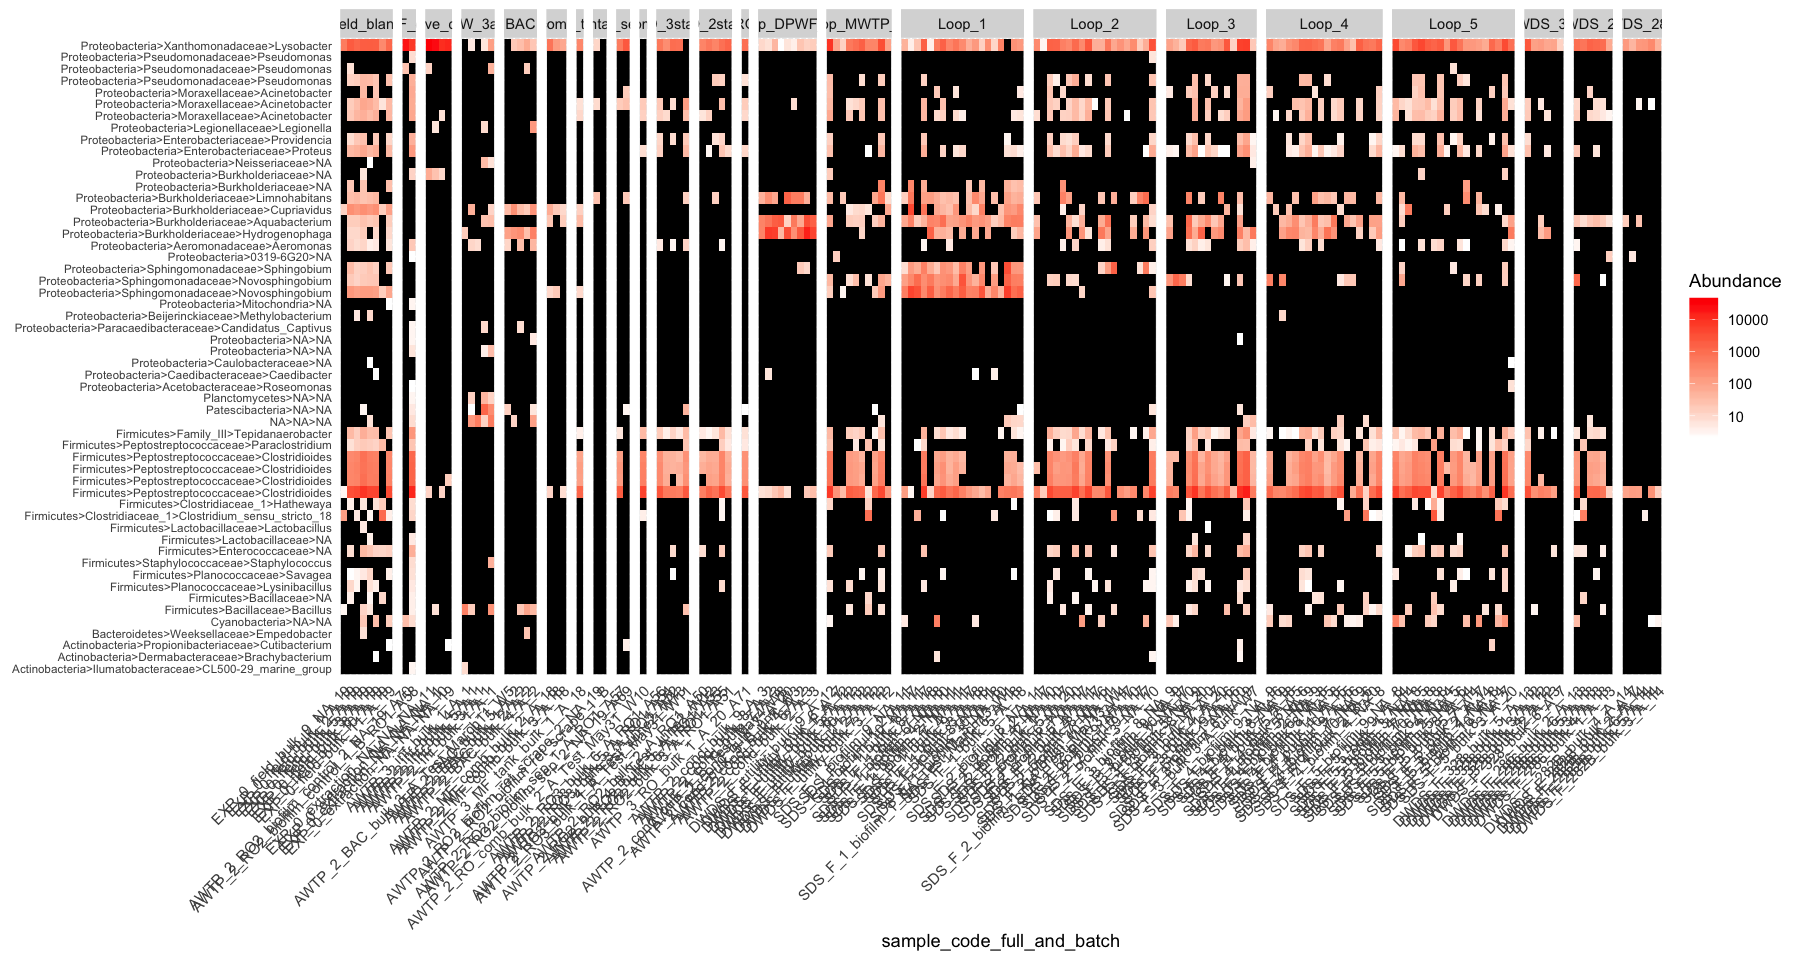

In [163]:
decontam_contams <- c(decontam_freq_intersect, decontam_prev_contams)
ps_decontam_contams <- prune_taxa(decontam_contams, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_decontam_contams, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_freq_prev_contams.png', device='png', width=20, height=9)

Warning message:
“Transformation introduced infinite values in discrete y-axis”

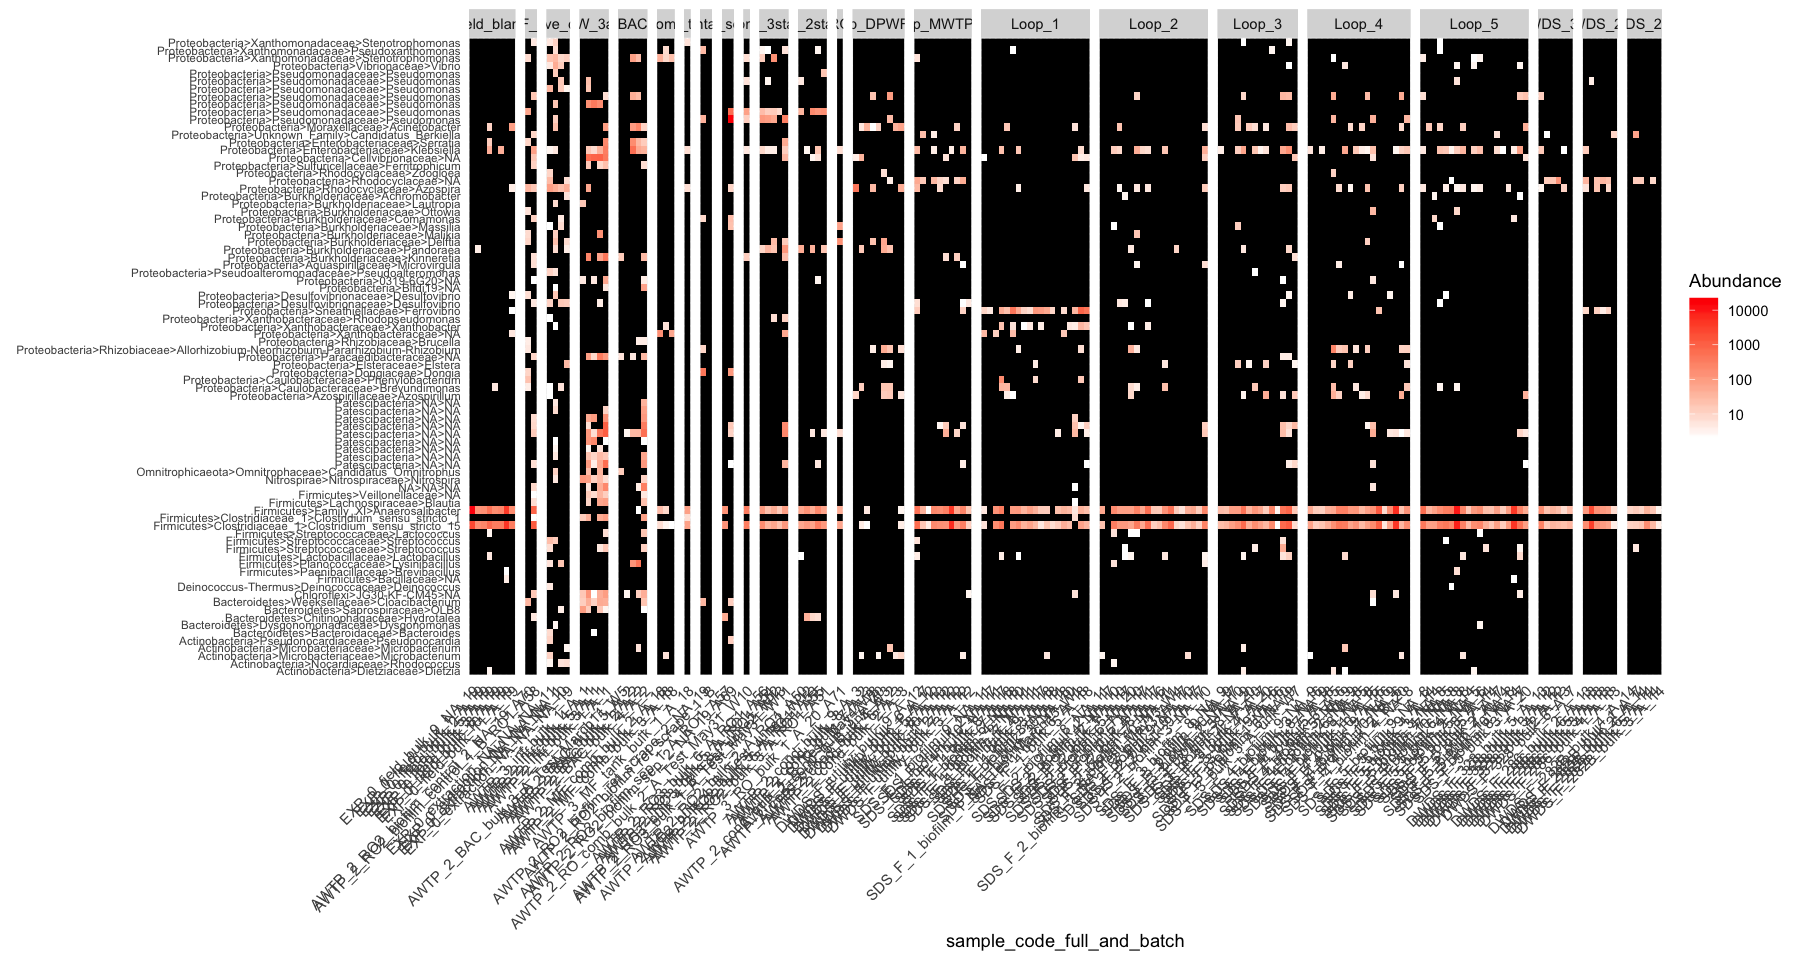

In [164]:
deseq_not_decontam <- setdiff(blanks_over_samples, decontam_contams)
ps_deseq_not_decontam <- prune_taxa(deseq_not_decontam, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 8)
plot_heatmap(ps_deseq_not_decontam, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_deseq_not_decontam.png', device='png', width=20, height=9)

**Conclusion: These are ASVs flagged by DESeq2 subtraction but not decontam. Several of these ASVs do look like contaminants that should be thrown out and were missed by `decontam`. Some look like they might be biological but the data is too sparse to be sure.  The DESeq2 method as applied here is more stringent than `decontam`, and we will go forward with it.**

Warning message:
“Transformation introduced infinite values in discrete y-axis”

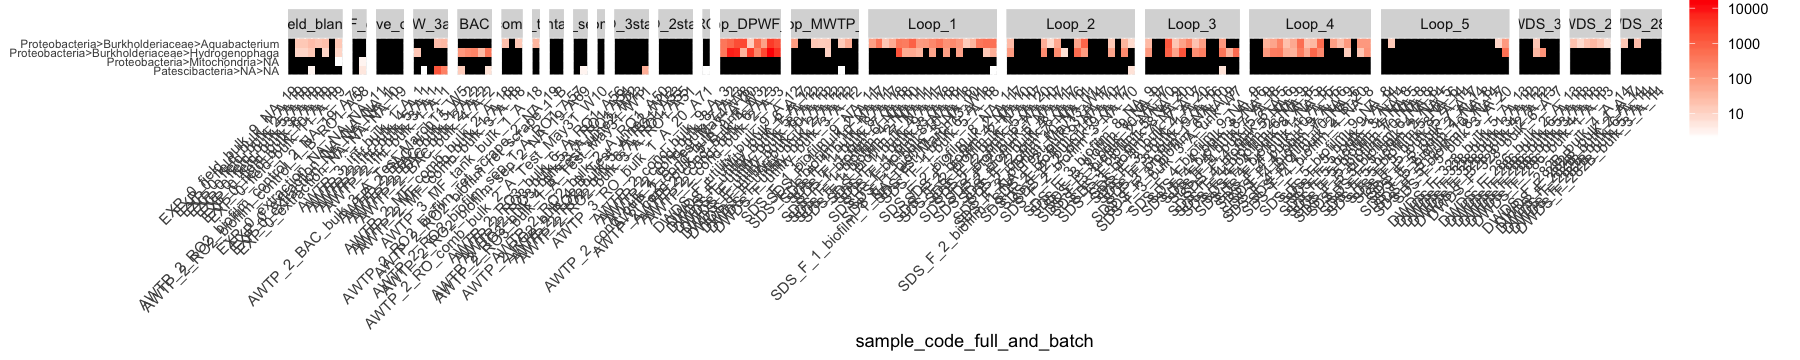

In [165]:
decontam_not_deseq <- setdiff(decontam_contams, blanks_over_samples)
ps_decontam_not_deseq <- prune_taxa(decontam_not_deseq, ps_samp_blank_for_decontam)

#plot heatmap
options(repr.plot.width = 15, repr.plot.height = 3)
plot_heatmap(ps_decontam_not_deseq, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", taxa.order='Family',
#method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")
#ggsave('~/data/awtp2_16S/heatmap_decontam_not_deseq.png', device='png', width=20, height=9)

**Conclusion: These are ASVs flagged by decontam but not DESeq2 subtraction. These are important ASVs that shouldn't be removed as contaminants. Likely their presence at very low abundance in the negative controls is due to cross-contamination from samples, where they are at high abundance.**